#  <font color='red'>Analyse des sentiments des phrases étiquetées</font> 

## 1-Exploration des données

In [192]:
import numpy as np
import pandas as pd

In [193]:
#lecture des donnees à partir fichier txt 
data = []
file = open("imdb_labelled.txt", "r")
for review in file:
    x = review.strip().split('\t')  
    data.append([x[0], int(x[1])]) 

In [194]:
#reprisentation sous forme un tableau
df = pd.DataFrame(data, columns=['review', 'sentiment']) 
df.head(10)

,review,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
5,"The rest of the movie lacks art, charm, meanin...",0
6,Wasted two hours.,0
7,Saw the movie today and thought it was a good ...,1
8,A bit predictable.,0
9,Loved the casting of Jimmy Buffet as the scien...,1


In [195]:
# description du tableau: 1000 lignes, 2 colonnes
df.shape

(1000, 2)

In [196]:
#tableau contient 500 review negatifs et 500 positifs
df.sentiment.value_counts()

0    500
1    500
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

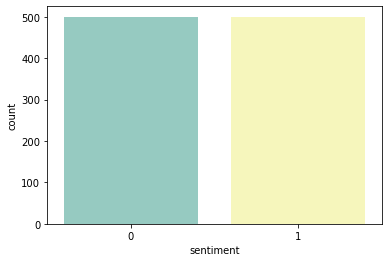

In [197]:
import seaborn as sns
sns.countplot(x="sentiment",data=df,palette="Set3")

## 2-Filtrage des données

In [198]:
import nltk #Natural Language Toolkit
import re #regex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

ps=nltk.stem.porter.PorterStemmer()

revs = df.review.copy() #liste des phrases
senti=df.sentiment.copy() #liste des sentiments

i=0
positiveTokens= [] # tokens du review  positif
negativeTokens= [] # tokens du review  negatif

#Exploration et tokeniser un review
def tokenize(phrase): 
    phrase = re.sub('[^a-zA-Z]', ' ', phrase).lower().split() #supprimer les caractères speciaux
    phrase = [nltk.WordNetLemmatizer().lemmatize(word) for word in phrase if not word in stopwords.words('english')] #lemmatizing
    phrase = ' '.join(phrase)
    phrase=word_tokenize(phrase) #tokenizing (phrase to array of words)
    return phrase

In [199]:
#separer les  positifs et negatifs tokens
for rev in revs:    #pour chaque review
    
    if senti[i]==0: #si sentiment est negatif
        
        negativeTokens.append(tokenize(rev)) #decomposer le review en liste de mots et l'ajouter a positiveTokens[['bad','worse'],['aimless','bored'],..]
         
    else:
        positiveTokens.append(tokenize(rev)) #decomposer le review en liste de mots et l'ajouter a positiveTokens
    i+=1

positiveTokens=(np.concatenate((positiveTokens), axis=0)) #  list de tout les positifs tokens ['bad','worse','aimless','bored']
negativeTokens=(np.concatenate((negativeTokens), axis=0)) # list de tout les negatifs tokens

## 3-Extraction des caractéristiques 

In [200]:
WordFreq=[]

#calculater frequence d'un mot (Number of occurences of a word in Tokens)
def wordFrequency(word,array): 
    wordFreq=np.count_nonzero(array==word)
    return wordFreq

#--------------------- VISUALISATION-------------------------
#create dataframe of [word,posFreq,negFreq]
for word in list(set(np.concatenate((positiveTokens,negativeTokens), axis=0))):
    WordFreq.append([word,wordFrequency(word,positiveTokens),wordFrequency(word,negativeTokens)]) #[word,posFreq,negFreq]
wordFreqDF = pd.DataFrame(WordFreq, columns=['word','positive Freq', 'negative Freq'])
wordFreqDF.head()
#---------------------------------------------------------------

,word,positive Freq,negative Freq
0,star,4,3
1,poor,0,6
2,trek,0,1
3,politics,1,0
4,stinker,0,1


In [205]:
DataSet=[]
  
#calculate row of dataset [review,PosF,NegF,sentiment]
def phraseFreq(phrase,sentiment):  
    Posfreq=0
    Negfreq=0
    cleanrev=tokenize(phrase)
    for word in cleanrev:
        Posfreq+=wordFrequency(word,positiveTokens) #la somme des frequences positifs
        Negfreq+=wordFrequency(word,negativeTokens) #la somme des frequences negatifs
    
    return [' '.join(cleanrev),Posfreq,Negfreq,sentiment]


#convert review(input) to vector(PosF,NegF)
def review2vec(review):
    Posfreq=0
    Negfreq=0
    for word in tokenize(phrase):
        Posfreq+=wordFrequency(word,positiveTokens)
        Negfreq+=wordFrequency(word,negativeTokens)
    return [Posfreq,Negfreq]


def createDataSet():
    i=0
    for rev in revs:
        DataSet.append(phraseFreq(rev,senti[i]))
        i+=1

createDataSet()

DataSet=pd.DataFrame(DataSet, columns=['review','PosF', 'NegF','sentiment'])
DataSet.head(100) 


,review,PosF,NegF,sentiment
0,slow moving aimless movie distressed drifting ...,117,124,0
1,sure lost flat character audience nearly half ...,42,40,0
2,attempting artiness black white clever camera ...,166,248,0
3,little music anything speak,19,23,0
4,best scene movie gerardo trying find song keep...,160,145,1
...,...,...,...,...
95,manna heaven terrific film predictable unpredi...,150,105,1
96,scene often funny occasionally touching charac...,89,59,1
97,cast veteran actor nostalgia trip,36,14,1
98,ursula burton portrayal nun touching funny tim...,62,34,1


<AxesSubplot:xlabel='PosF', ylabel='count'>

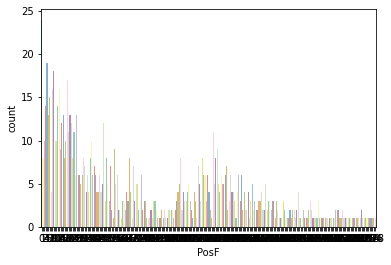

In [210]:
sns.countplot(x="PosF",data=DataSet,palette="Set3")


<AxesSubplot:xlabel='NegF', ylabel='count'>

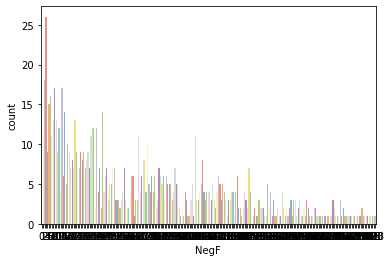

In [211]:
sns.countplot(x="NegF",data=DataSet,palette="Set3")

## 4-Echantillonnage 

In [ ]:
# Import sklearn 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import scale
from sklearn import datasets
import seaborn as sns  # Bibliothèque pour la visualisation des données

In [ ]:
# Données + classes cibles
#on va s'intéresser aux freq et sentiment
data   = np.array(DataSet.values[:,1:3], dtype=np.float32)
target = DataSet.values[:,-1]
print(data[0],target[0])

In [ ]:
#Partition aléatoire de l’échantillon
# 10%=100 exemples pour le test
(trainX, testX, trainY, testY) = train_test_split(data, target, test_size=0.1)

len(testY)



In [ ]:
# Transformer l'étiquette(sentiments) en un vecteur binaire :
trainYC = np.array(list(map(lambda x: [1,0] if x == 1 else [0,1], trainY)))
testYC = np.array(list(map(lambda x: [1,0] if x == 1 else [0,1], testY)))


trainYC
#positif --> [1,0]  negatif --> [0,1] [proba d'etre positif,proba d'etre negatif]


## 5-Perceptron multi-couches

In [ ]:
class MultiLayerPerceptron:
    
    def __init__(self, arch , alpha = 0.1):
        # poids + biais
        self.W = {}
        self.B = {}
        
        # Taux d'adaptation
        self.alpha = alpha
        
        # Architecture :nbre de couches et nombre de neurones par couche
        self.arch = arch
        
        # Initialisation des poids: valeurs issues d'une distribution normale
        for i in np.arange(1,len(self.arch)):  
            # Poids
            w = np.random.randn(self.arch[i], self.arch[i-1])
            self.W[i] = w/np.sqrt(self.arch[i])
            # Bias
            b = np.random.randn(self.arch[i],1)
            self.B[i] = b/np.sqrt(self.arch[i])            
            
            
    def sigmoid(self, x):
        return 1.0/(1 + np.exp(-x))
    
    
    def dsigmoid(self, x): # x correspond ici à sigmoid(uj(t))
        return x * (1 - x)
    
    
    #Calcul et mémorisation de l'état de tous les neurones du réseau 
    def forward_pass(self, x):
        a = np.atleast_2d(x).T
        
        stats = {}
        stats[0] = a
        for layer in np.arange(1, len(self.arch)):
            a = self.sigmoid(np.dot(self.W[layer], a) + self.B[layer])
            stats[layer] = a
        return stats    
    
    
    #Sortie du réseau associée à une entrée X (les états des autres neurones ne sont pas mémorisés)
    def predict(self, X):
        a = np.atleast_2d(X).T
        for layer in np.arange(1, len(self.arch)):
            a = self.sigmoid(np.dot(self.W[layer], a) + self.B[layer])
        return a
    
    
    #Calcul de l'erreur quadratique moyenne
    def quadratic_loss(self, X, Y):
        Y = np.atleast_2d(Y).T
        predictions = self.predict(X)
        n = X.shape[0]
        loss = (1/n) * 0.5 * np.sum((predictions - Y) ** 2) 
        return loss 
    
    
    #Calcul des gradients locaux 
    def compute_gradient(self, x, y):
     
        L = len(self.arch) - 1 # indice de la couche de sortie 
        # Gradients
        Gw = {}
        Gb = {}
        A = self.forward_pass(x)
        # Les vecteurs delta  
        D = {}
        y = np.atleast_2d(y).T
        deltaL = (A[L] - y) * self.dsigmoid(A[L])
        D[L] = deltaL # Pour la sortie 
        
        # Calculer les vecteurs delta des autres couches en utilisants les vecteurs delta de la couche suivante
        for l in np.arange(L-1, 0, -1):
            D[l] = (self.W[l+1].T.dot(D[l+1])) * self.dsigmoid(A[l])
        
        for l in np.arange(L, 0, -1):
            Gb[l] = D[l]
            Gw[l] = D[l].dot(A[l-1].T)        
       
        return (Gw, Gb)
    
    
    # Mise à jour par rapport à l'erreur moyenne (relative à un bloc d'exemples)
    def update_with_bloc(self, bloc):
      
        m = len(bloc)
        # Gradients locaux
        GCw = {}
        GCb = {}
        # Initialiser à zeros 
        for i in np.arange(1,len(self.arch)):
            GCw[i] = np.zeros(self.W[i].shape)
            GCb[i] = np.zeros(self.B[i].shape)
            
        # Calcul des gradients
        for x, y in bloc:
            Gw, Gb = self.compute_gradient(x, y)
            for i in np.arange(1,len(self.arch)): 
                GCw[i] += Gw[i]
                GCb[i] += Gb[i]
                
        # Mettre à jour les poids 
        for l in np.arange(1,len(self.arch)):
            self.W[l] = self.W[l] - (self.alpha/m)*(GCw[l])
            self.B[l] = self.B[l] - (self.alpha/m)*(GCb[l])
    
    
    # Iteration: entrainement en utilisant tous les exemples, un bloc de taille bloc_size chaque fois
    def train(self, D, bloc_size):
        train_size = len(D)
        np.random.shuffle(D) # tirage au sort
        
        # Bloc d'exemples
        blocs = [D[k : k + bloc_size] for k in range(0, train_size, bloc_size)]
        
        for bloc in blocs: # Mise à jour suite au passage de chaque bloc
            self.update_with_bloc(bloc)
  

    # Apprentissage
    def fit(self, X, Y, bloc_size = 20, iterations = 10000, error_min = 0.001, displayPeriod = 5000):
     
        # Exemples avec X et Y Assemblés
        D = list(zip(X,Y))
        
        # Erreurs
        errors = [self.quadratic_loss(X,Y)]   # Erreur initiale    
        
        iter = 0
        print("Itération: {}-{}, Erreur: {:.6f}".format(iter, iterations,errors[iter]))
        while iter < iterations and errors[iter] > error_min: # Tour de boucle 
            
            self.train(D, bloc_size)  # Mettre à jour 
            errors.append(self.quadratic_loss(X,Y))         # Nouvelle erreur
          
            if (iter+1) % displayPeriod == 0:
                print("Itération: {}-{}, Error: {:.6f}".format(iter + 1, iterations,errors[iter]))
            iter += 1
        
        if errors[iter] < error_min: # Erreur inférieur à la valeur minimale
            print("Fin: erreur minimale atteinte : {:.6f}.", errors[iter])
        elif iter == iterations:
            print("Fin: nombre maximum d'itérations atteint.")
       
        return (errors, iter)

## 6-Initialisation et apprentissage

In [ ]:
#500 itterations d'apprentissage avec un reseaux de 4 couches        
pmc = MultiLayerPerceptron(arch=[trainX.shape[1],5,5,2], alpha=0.001)
(errs, iter_fin) = pmc.fit(trainX, trainYC, iterations=500, bloc_size=5, error_min=0.00001, displayPeriod=20)

In [ ]:
# Test pour un exemple 
#choisissant la ligne 7 
#ses donnees exactes
print(testX[7])
print(testY[7])
#les données predictées
print('Sortie prédite : \n'+str(pmc.predict(testX[7]))+')' )


## 7-Testing

In [ ]:
targetTestR = ['']*(np.array(testY).shape[0])

# targetTestR
for index in range(testX.shape[0]):     
    o = np.round(pmc.predict(testX[index]),0)[:,0].astype(int)
    if((o==np.array([1,0])).all()):
        targetTestR[index] = 1
    elif((o==np.array([0,1])).all()):
        targetTestR[index] = 0

        
# Sortie calculée et sortie réelle pour la base de test      
targetTestRF=list(map(lambda x: '1' if x == 1 else '0', targetTestR))
# print(targetTestR)
testYF=list(map(lambda x: '1' if x == 1 else '0', testY))
print(testYF)

## 8-Précision

In [ ]:
from sklearn import metrics
# Taux de la classification correcte 
metrics.accuracy_score(testYF, targetTestRF) 

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix=confusion_matrix(testYF, targetTestRF)


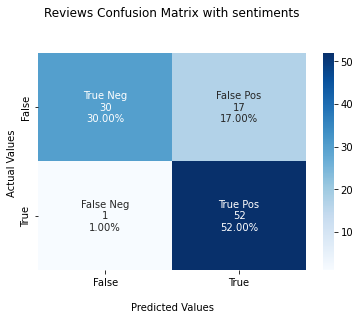

In [204]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Reviews Confusion Matrix with sentiments\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()